# Facebook Prophet and K-Means Clustering

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [8]:
import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [9]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

### Basic Training and Prediction

In [10]:
# Predict on the number of confirmed cases per day
cases = pd.read_csv("data/us/covid/confirmed_cases.csv")

In [11]:
# Tell Prophet to assume seasonality grows with the trendline
m = Prophet(seasonality_mode="multiplicative")
m.fit(la)

NameError: name 'la' is not defined

In [12]:
# Construct dates 20 days into the future from the most recent training data point
future = m.make_future_dataframe(periods=20)
future.tail()

Exception: Model has not been fit.

In [6]:
forecast = m.predict(future)

NameError: name 'm' is not defined

In [151]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
91,2020-04-22,5519.580900,4933.020389,5450.187118,5286.431832,5784.714373,-0.062265,-0.062265,-0.062265,-0.062265,-0.062265,-0.062265,0.0,0.0,0.0,5175.903299
92,2020-04-23,5691.302551,5190.312799,5775.118940,5438.431317,5970.725076,-0.038811,-0.038811,-0.038811,-0.038811,-0.038811,-0.038811,0.0,0.0,0.0,5470.416203
93,2020-04-24,5863.024203,5529.617230,6175.774176,5584.419343,6174.877644,-0.005299,-0.005299,-0.005299,-0.005299,-0.005299,-0.005299,0.0,0.0,0.0,5831.957894
94,2020-04-25,6034.745854,6197.238121,6978.106960,5724.701457,6374.502877,0.089104,0.089104,0.089104,0.089104,0.089104,0.089104,0.0,0.0,0.0,6572.464210
95,2020-04-26,6206.467505,6324.917331,7178.099255,5864.481258,6582.383083,0.084310,0.084310,0.084310,0.084310,0.084310,0.084310,0.0,0.0,0.0,6729.737071


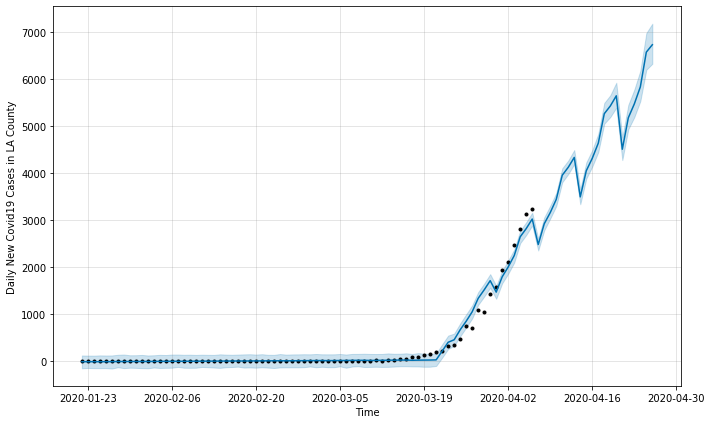

In [152]:
fig1 = m.plot(forecast, xlabel="Time", ylabel="Daily New Covid19 Cases in LA County")

### Using Population Data and KMeans Clustering

In [13]:
population = pd.read_csv("data/us/demographics/county_populations.csv")

In [14]:
# Reformat data to be change as a percentage of population
la_population = int(population.loc[population["FIPS"] == 6037]["total_pop"])
print(la_population)

10105722


In [15]:
la["y"] = la["y"] / la_population

NameError: name 'la' is not defined

In [16]:
county_density = pd.read_csv("data/us/demographics/county_land_areas.csv", encoding="cp1252", dtype={"County FIPS": str})
county_density = county_density.drop(["County Name", "Area in square miles - Total area", "Area in square miles - Land area"], axis=1)

# Combine the datasets, currently omitting counties without information for both
county_data = county_density.copy()
county_data["total_pop"] = 0
county_data["60plus"] = 0
to_drop = []

for idx, row in county_data.iterrows():
    fips = row["County FIPS"]
    pop_row = population.loc[population["FIPS"] == int(fips)]
    if not pop_row.empty:
        county_data.at[idx, "total_pop"] = pop_row["total_pop"]
        county_data.at[idx, "60plus"] = pop_row["60plus"]
    else:
        to_drop.append(idx)

county_data.drop(county_data.index[to_drop], inplace=True)
print("Dropped", len(to_drop), "counties.")

Dropped 81 counties.


In [17]:
county_data["proportion_60plus"] = county_data["60plus"] / county_data["total_pop"]
county_data.drop(["total_pop", "60plus"], axis=1, inplace=True)

In [18]:
hospital_beds = pd.read_csv("data/us/hospitals/beds_by_county.csv")
mobility = pd.read_csv("data/us/mobility/DL-us-m50_index.csv")

county_data["bed_density"] = 0.0
county_data["mobility"] = 0.0
to_drop = []

for idx, row in county_data.iterrows():
    fips = row["County FIPS"]
    h_row = hospital_beds.loc[hospital_beds["FIPS"] == int(fips)]
    m_row = mobility.loc[mobility["fips"] == int(fips)]
    if not h_row.empty and not m_row.empty:
        try:
            county_data.at[idx, "bed_density"] = h_row["staffed_beds"]
            county_data.at[idx, "mobility"] = m_row["2020-04-04"]
        except Exception as e:
            county_data.at[idx, "bed_density"] = h_row.iloc[0]["staffed_beds"]
            county_data.at[idx, "mobility"] = m_row.iloc[0]["2020-04-04"]
    elif idx < len(county_data):
        to_drop.append(idx)

county_data.drop(county_data.index[to_drop], inplace=True)
print("Dropped", len(to_drop), "counties.")

Dropped 897 counties.


In [19]:
county_data.dropna(inplace=True)
num_clusters = 8

km = KMeans(n_clusters=num_clusters)
km = km.fit(county_data[["2010 Density per square mile of land area - Population", "2010 Density per square mile of land area - Housing units", "proportion_60plus", "bed_density", "mobility"]])
county_data.loc[:, "cluster"] = km.labels_

In [20]:
la_cluster = int(county_data.loc[county_data["County FIPS"] == "6037"]["cluster"])
print("LA cluster:", la_cluster)
print("Number of counties in this cluster:", len(county_data.loc[county_data["cluster"] == la_cluster]))

LA cluster: 4
Number of counties in this cluster: 3


In [21]:
cluster_counties = county_data.loc[county_data["cluster"] == la_cluster] 

In [22]:
cluster_counties.head()

,County FIPS,2010 Density per square mile of land area - Population,2010 Density per square mile of land area - Housing units,proportion_60plus,bed_density,mobility,cluster
204,6037,2419.6,849.0,0.178151,22916.0,1.0,4
610,17031,5495.1,2306.5,0.191856,18615.0,0.0,4
2623,48201,2402.4,938.5,0.144000,14802.0,3.0,4


In [23]:
# Get date and case information
case_rows = []
case_rows.append(cases.loc[cases["countyFIPS"] == 6037])
case_rows.append(cases.loc[cases["countyFIPS"] == 17031])
case_rows.append(cases.loc[cases["countyFIPS"] == 48201])

In [24]:
data = []
for row in case_rows:
    counter = 0
    ds, y = [], []
    for item in row.iteritems():
        if counter > 3: 
            ds.append(item[0])
            y.append(int(item[1]))
        counter += 1
    d = pd.DataFrame(data = {"ds": ds, "y": y})
    data.append(d)

In [25]:
pops = [int(population.loc[population["FIPS"] == 6037]["total_pop"]),\
       int(population.loc[population["FIPS"] == 17031]["total_pop"]),\
       int(population.loc[population["FIPS"] == 48201]["total_pop"])]
print(pops)

[10105722, 5238541, 4525519]


In [26]:
for i, d in enumerate(data):
    d["y"] /= pops[i]

In [27]:
# Align when 0.0001 = 0.01% of the population was infected
idx_001 = [0, 0, 0]
for i, row in data[0].iterrows():
    for n, d in enumerate(data):
        if data[n].at[i, "y"] >= 0.0001 and idx_001[n] == 0: idx_001[n] = i
    if all(idx != 0 for idx in idx_001): break

In [28]:
print(idx_001)

[64, 59, 68]


In [29]:
data[0]["data0"], data[0]["data1"], data[0]["data2"] = 0, 0, 0

In [30]:
# Shift data based on calculated indices
dif1, dif2 = idx_001[0] - idx_001[1], idx_001[0] - idx_001[2]
for i, row in data[0].iterrows():
    data[0].loc[i, "data0"] = data[0].at[i, "y"]
    if i - dif1 >= 0 and i - dif1 < len(data[1]):
        data[0].loc[i, "data1"] = data[1].at[i - dif1, "y"]
        
    if i - dif2 >= 0 and i - dif2 < len(data[2]):
        data[0].loc[i, "data2"] = data[2].at[i - dif2, "y"]
    
    avg = []
    for n in range(3): 
        num = data[0].at[i, "data" + str(n)]
        if num != 0: avg.append(num)
    
    if len(avg) != 0: data[0].loc[i, "y"] = sum(avg) / len(avg)
    
# Differencing
for i, row in data[0].iterrows():
    if i != 0: data[0].loc[i, "y"] = data[0].loc[i, "y"] - data[0].loc[i - 1, "y"]

In [31]:
cp = Prophet(seasonality_mode = "multiplicative")
cp.fit(data[0])

In [32]:
future = cp.make_future_dataframe(periods=20)
future.tail()

,ds
124,2020-05-25
125,2020-05-26
126,2020-05-27
127,2020-05-28
128,2020-05-29


In [33]:
forecast = cp.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
124,2020-05-25,0.00350,0.003011,0.003343,0.003423,0.003587,-0.094933,-0.094933,-0.094933,-0.094933,-0.094933,-0.094933,0.0,0.0,0.0,0.003168
125,2020-05-26,0.00357,0.003148,0.003486,0.003485,0.003667,-0.071158,-0.071158,-0.071158,-0.071158,-0.071158,-0.071158,0.0,0.0,0.0,0.003316
126,2020-05-27,0.00364,0.004132,0.004524,0.003549,0.003748,0.184446,0.184446,0.184446,0.184446,0.184446,0.184446,0.0,0.0,0.0,0.004312
127,2020-05-28,0.00371,0.003315,0.003661,0.003612,0.003829,-0.062010,-0.062010,-0.062010,-0.062010,-0.062010,-0.062010,0.0,0.0,0.0,0.003480
128,2020-05-29,0.00378,0.004277,0.004695,0.003675,0.003910,0.182905,0.182905,0.182905,0.182905,0.182905,0.182905,0.0,0.0,0.0,0.004472


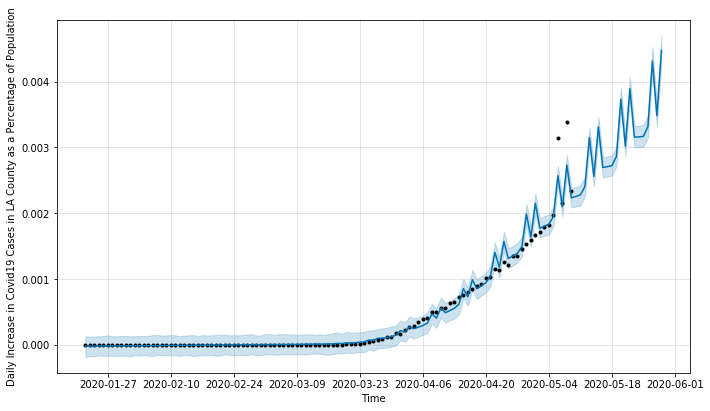

In [34]:
fig2 = cp.plot(forecast, xlabel="Time", ylabel="Daily Increase in Covid19 Cases in LA County as a Percentage of Population")

In [35]:
# WITHOUT CLUSTERING
fig1

NameError: name 'fig1' is not defined

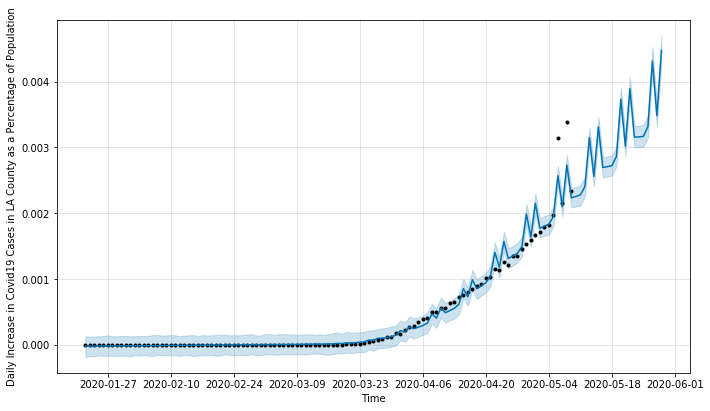

In [36]:
# WITH CLUSTERING
fig2

# Testing Prophet on Different Sized Counties With Different Trend Sensitivities

In [37]:
data = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")

In [38]:
# Just using raw case data, no differencing, etc
nyc_fips = 36061
big_fips = 6037
big_fips_2 = 17031
med_fips = 12011
sm_fips = 6081

n_row = data.loc[data["fips"] == nyc_fips]
b_row = data.loc[data["fips"] == big_fips]
b_row_2 = data.loc[data["fips"] == big_fips_2]
m_row = data.loc[data["fips"] == med_fips]
s_row = data.loc[data["fips"] == sm_fips]

test_per = 14

Cumulative deaths: 19324


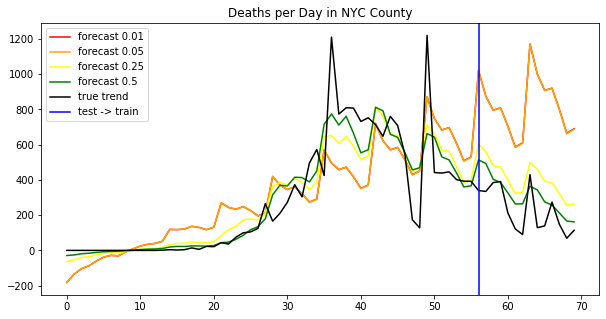

In [39]:
# NYC

cum_deaths = 0
ds, y = [], []
for i, item in n_row.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
    
print("Cumulative deaths:", cum_deaths)

df = pd.DataFrame(data = {"ds": ds, "y": y})
df_train = df.iloc[:-test_per]

plt.figure(figsize = (10, 5))

for changept, color in [(0.01, "red"), (0.05, "orange"), (0.25, "yellow"), (0.5, "green")]:
    print(changept, end='\r', flush=True)
    m = Prophet(seasonality_mode="multiplicative", interval_width = 0.95, changepoint_prior_scale = changept)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=test_per)
    forecast = m.predict(future)
    plt.plot(forecast["yhat"], label = 'forecast ' + str(changept), c = color)

plt.plot(df["y"], label = 'true trend', c = 'black')
plt.title("Deaths per Day in NYC County")
plt.axvline(len(forecast) - test_per, 0, 1, label='test -> train', c = 'blue')
plt.legend()
plt.show()

Cumulative deaths: 1512


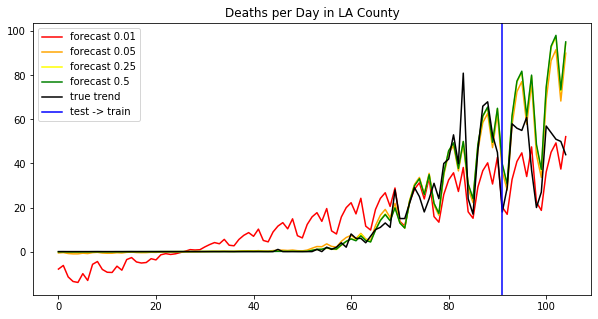

In [40]:
# Big county

cum_deaths = 0
ds, y = [], []
for i, item in b_row.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
    
print("Cumulative deaths:", cum_deaths)

df = pd.DataFrame(data = {"ds": ds, "y": y})
df_train = df.iloc[:-test_per]

plt.figure(figsize = (10, 5))

for changept, color in [(0.01, "red"), (0.05, "orange"), (0.25, "yellow"), (0.5, "green")]:
    print(changept, end='\r', flush=True)
    m = Prophet(seasonality_mode="multiplicative", interval_width = 0.95, changepoint_prior_scale = changept)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=test_per)
    forecast = m.predict(future)
    plt.plot(forecast["yhat"], label = 'forecast ' + str(changept), c = color)

plt.plot(df["y"], label = 'true trend', c = 'black')
plt.title("Deaths per Day in LA County")
plt.axvline(len(forecast) - test_per, 0, 1, label='test -> train', c = 'blue')
plt.legend()
plt.show()

Cumulative deaths: 2264


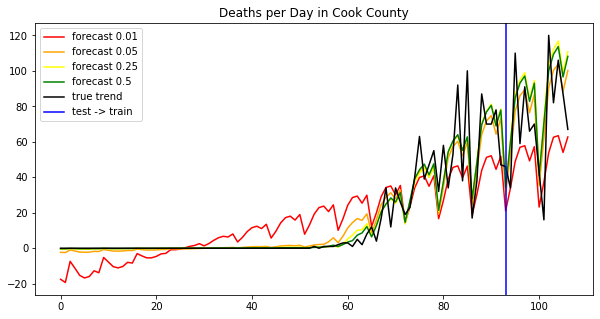

In [41]:
# Another big county

cum_deaths = 0
ds, y = [], []
for i, item in b_row_2.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
    
print("Cumulative deaths:", cum_deaths)

df = pd.DataFrame(data = {"ds": ds, "y": y})
df_train = df.iloc[:-test_per]

plt.figure(figsize = (10, 5))

for changept, color in [(0.01, "red"), (0.05, "orange"), (0.25, "yellow"), (0.5, "green")]:
    print(changept, end='\r', flush=True)
    m = Prophet(seasonality_mode="multiplicative", interval_width = 0.95, changepoint_prior_scale = changept)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=test_per)
    forecast = m.predict(future)
    plt.plot(forecast["yhat"], label = 'forecast ' + str(changept), c = color)

plt.plot(df["y"], label = 'true trend', c = 'black')
plt.title("Deaths per Day in Cook County")
plt.axvline(len(forecast) - test_per, 0, 1, label='test -> train', c = 'blue')
plt.legend()
plt.show()

Cumulative deaths: 257


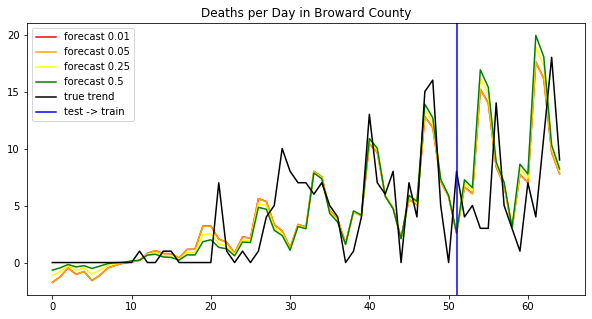

In [42]:
# Medium county

cum_deaths = 0
ds, y = [], []
for i, item in m_row.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
    
print("Cumulative deaths:", cum_deaths)

df = pd.DataFrame(data = {"ds": ds, "y": y})
df_train = df.iloc[:-test_per]

plt.figure(figsize = (10, 5))

for changept, color in [(0.01, "red"), (0.05, "orange"), (0.25, "yellow"), (0.5, "green")]:
    print(changept, end='\r', flush=True)
    m = Prophet(seasonality_mode="multiplicative", interval_width = 0.95, changepoint_prior_scale = changept)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=test_per)
    forecast = m.predict(future)
    plt.plot(forecast["yhat"], label = 'forecast ' + str(changept), c = color)

plt.plot(df["y"], label = 'true trend', c = 'black')
plt.title("Deaths per Day in Broward County")
plt.axvline(len(forecast) - test_per, 0, 1, label='test -> train', c = 'blue')
plt.legend()
plt.show()

Cumulative deaths: 62


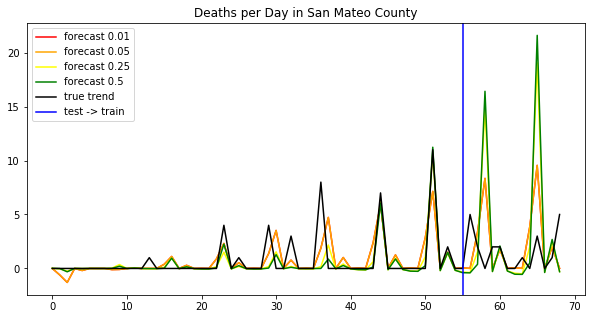

In [43]:
# Small county

cum_deaths = 0
ds, y = [], []
for i, item in s_row.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
    
print("Cumulative deaths:", cum_deaths)

df = pd.DataFrame(data = {"ds": ds, "y": y})
df_train = df.iloc[:-test_per]

plt.figure(figsize = (10, 5))

for changept, color in [(0.01, "red"), (0.05, "orange"), (0.25, "yellow"), (0.5, "green")]:
    print(changept, end='\r', flush=True)
    m = Prophet(seasonality_mode="multiplicative", interval_width = 0.95, changepoint_prior_scale = changept)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=test_per)
    forecast = m.predict(future)
    plt.plot(forecast["yhat"], label = 'forecast ' + str(changept), c = color)

plt.plot(df["y"], label = 'true trend', c = 'black')
plt.title("Deaths per Day in San Mateo County")
plt.axvline(len(forecast) - test_per, 0, 1, label='test -> train', c = 'blue')
plt.legend()
plt.show()

# Generating a Submission

In [44]:
fips_list = pd.read_csv("data/us/processing_data/fips_key.csv", encoding="cp1252")
fips_list.head()

,FIPS,MSA/PMSA NECMA,ST,COUNTY
0,1001,5240,AL,Autauga County
1,1003,5160,AL,Baldwin County
2,1005,0,AL,Barbour County
3,1007,0,AL,Bibb County
4,1009,1000,AL,Blount County


In [45]:
test_per = 0
predict_per = 18

data = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
data.head()

,fips,date,county,state,cases,deaths
0,53061,2020-01-21,Snohomish,Washington,1.0,0.0
1,53061,2020-01-22,Snohomish,Washington,0.0,0.0
2,53061,2020-01-23,Snohomish,Washington,0.0,0.0
3,53061,2020-01-24,Snohomish,Washington,0.0,0.0
4,53061,2020-01-25,Snohomish,Washington,0.0,0.0


In [46]:
print(str(datetime.datetime.now())+"\n")

ids, i10, i20, i30, i40, i50, i60, i70, i80, i90 = [], [], [], [], [], [], [], [], [], []
z_80 = 1.28
z_60 = 0.84
z_40 = 0.525
z_20 = 0.25

for idx, row in fips_list.iterrows():
    county = int(row["FIPS"])
    print("County " + str(county) + "...", end='\r', flush=True)
    c_row = data.loc[data["fips"] == county]
    c_row.reset_index(inplace=True)
    
    # Construct the input dataframe
    cum_deaths = 0
    ds, y, prev_cases = [], [], []
    for i, item in c_row.iterrows():
        ds.append(item["date"])
        y.append(int(item["deaths"]))
        cum_deaths += int(item["deaths"])
        
        if i >= 14:
            prev_cases.append(c_row.iloc[i - 14]["cases"])
        else:
            prev_cases.append(0)

    df = pd.DataFrame(data = {"ds": ds, "y": y, "prev_cases": prev_cases})
    if test_per > 0:
        df_train = df.iloc[:-test_per]
    else:
        df_train = df.iloc[:]
        
    df_train.fillna(0, inplace=True)
    
    if cum_deaths > 15:
        m = Prophet(seasonality_mode="multiplicative", interval_width = 0.68)
        #m.add_regressor("prev_cases")
        m.fit(df_train)
        future = m.make_future_dataframe(periods=predict_per+test_per)
        
        """future["prev_cases"] = 0
        for i, rw in future.iterrows():
            date = rw["ds"]
            future.at[i, "prev_cases"] = int(c_row.loc[c_row["date"] == str(date)[:10]]["cases"])"""
        
        forecast = m.predict(future)

        for i, pred in forecast.iterrows():
            date = pred["ds"]
            upper = pred["yhat_upper"]
            lower = pred["yhat_lower"]
            mid = pred["yhat"]
            sd = upper - mid

            this_id = str(date)[:10] + "-" + str(county)
            ids.append(this_id)
            i10.append(mid - sd * z_80)
            i20.append(mid - sd * z_60)
            i30.append(mid - sd * z_40)
            i40.append(mid - sd * z_20)
            i50.append(mid)
            i60.append(mid + sd * z_20)
            i70.append(mid + sd * z_40)
            i80.append(mid + sd * z_60)
            i90.append(mid + sd * z_80)

    # Set all predictions to 0 for counties with few deaths to avoid weird spikes in predictions
    else:
        for date in ['2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17','2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25','2020-05-26']:
            this_id = str(date)[:10] + "-" + str(county)
            ids.append(this_id)
            i10.append(0)
            i20.append(0)
            i30.append(0)
            i40.append(0)
            i50.append(0)
            i60.append(0)
            i70.append(0)
            i80.append(0)
            i90.append(0)

print("\n" + str(datetime.datetime.now()))

2020-05-10 23:51:22.210320

County 78030...
2020-05-11 00:04:05.492929


In [47]:
predictions = pd.DataFrame(data={"id":ids, "10":i10, "20":i20, "30":i30, "40":i40, "50":i50, "60":i60, "70":i70, "80":i80, "90":i90})

In [48]:
predictions.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-05-10-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-05-11-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-05-12-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-05-13-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-05-14-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Set all predictions < 1 to 0
predictions["10"] = predictions["10"].apply(lambda x: x if x >= 1 else 0)
predictions["20"] = predictions["20"].apply(lambda x: x if x >= 1 else 0)
predictions["30"] = predictions["30"].apply(lambda x: x if x >= 1 else 0)
predictions["40"] = predictions["40"].apply(lambda x: x if x >= 1 else 0)
predictions["50"] = predictions["50"].apply(lambda x: x if x >= 1 else 0)
predictions["60"] = predictions["60"].apply(lambda x: x if x >= 1 else 0)
predictions["70"] = predictions["70"].apply(lambda x: x if x >= 1 else 0)
predictions["80"] = predictions["80"].apply(lambda x: x if x >= 1 else 0)
predictions["90"] = predictions["90"].apply(lambda x: x if x >= 1 else 0)

In [50]:
# Optional, remove NY counties from predictions
to_drop = []
for i, r in pred.iterrows():
    FIPS = int(r["id"].split('-')[-1])
    if FIPS >= 36000 and FIPS <= 36124: to_drop.append(i)

predictions = predictions.drop(to_drop, axis="index")

AttributeError: 'Series' object has no attribute 'iterrows'

In [51]:
predictions.to_csv("checkpoint2_submissions/prophet_predictions.csv", index=False)

In [16]:
# Author: Jake Will 
#
# A script that allows us to locally evaluate our model's performance

# Requires two NumPy arrays as input, the truth in y_true and predictions in y_pred. 
# The quantile should be a number between 0 and 1. I copied this code from the
# piazza post describing how to compute the pinball loss.
def pinball_loss(y_true, y_pred, quantile = 0.5):
    delta = y_true - y_pred
    # Compute loss for underestimates. 
    loss_above = np.sum(delta[delta > 0]) * (quantile)
    # Compute loss for overestimates.
    loss_below = np.sum(-1 * delta[delta < 0]) * (1 - quantile)
    return (loss_above + loss_below) / len(y_true)

# Input the name of the submission file to evaluate here
submission_file = "prophet_predictions.csv"

# Input the desired dates into these lists - both lists
# need to be updated because the files have different
# date formats

nyt_dates = ['4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20', '4/15/20', '4/16/20', '4/17/20', '4/18/20', '4/19/20', '4/20/20', '4/21/20', '4/22/20']
submission_dates = ['2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22']

# Because the files use different date formats, we'll use a map to
# be able to easily get the nyt dates from the submission dates.
# If things get significantly more complicated as the project
# continues, we might consider using a date-time library, but for
# now this should be sufficient.

submission_to_nyt_date = {}
for i, date in enumerate(submission_dates):
    submission_to_nyt_date[date] = nyt_dates[i]

# Compute the submission predictions
submission = pd.read_csv(submission_file)
submission = submission[submission['id'].str.contains(('|'.join(submission_dates)))]

# Compute the actual results
deaths = pd.read_csv("data/us/covid/nyt_us_counties_daily.csv")
deaths = deaths[['date', 'fips', 'deaths']]
deaths = deaths[deaths['date'].str.contains(('|'.join(submission_dates)))]

# Generate a numpy array of the actual results in the same order
# as the submission. If a county has no reported deaths, we assume
# that is has 0.

truth = np.empty(len(submission['id'].values))
for i, submission_id in enumerate(submission['id'].values):
    # Extract the FIPS and date from the id column of the submission
    FIPS = int(submission_id.split('-')[-1])
        
    date = '-'.join(submission_id.split('-')[:-1])

    # Extract the relevant row of the nyt deaths data
    df = deaths.loc[deaths['fips'] == FIPS]
    df = df.loc[deaths['date'] == date]

    # Set the truth numpy array accordingly
    if df.empty:
        truth[i] = 0
    else:
        truth[i] = df['deaths']

# Compute the pinball score using the given dates, submission, and
# truth values
score = 0.0
for column in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    score = score + pinball_loss(truth, submission[str(column)].values, quantile = column / 100.0)

score = score/9.0

print(score)

0.15018109729799464


# Averaging with ARIMA

In [3]:
prophet = pd.read_csv("prophet_dropny.csv")
arima = pd.read_csv("submission_without_ny.csv")

In [8]:
prophet.head()

,id,10,20,30,40,50,60,70,80,90
4536,2020-04-06-10001,0.000000,0.000000,0.000000,0.000000,0.000000,3.445610e-12,7.877329e-12,1.295366e-11,2.004441e-11
4550,2020-04-06-10003,0.000000,0.000000,0.000000,0.000000,0.000282,9.895674e-02,2.074992e-01,3.318297e-01,5.054978e-01
4564,2020-04-06-10005,1.307416,1.419589,1.499895,1.570003,1.633738,1.697472e+00,1.767581e+00,1.847886e+00,1.960060e+00
0,2020-04-06-1001,0.000000,0.000000,0.000000,0.000000,0.000000,2.894943e-10,6.079381e-10,9.727010e-10,1.482211e-09
14,2020-04-06-1003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.157977e-12,2.878176e-12


In [9]:
arima.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
prophet = prophet.sort_values("id")
arima = arima.sort_values("id")

In [10]:
predictions = prophet.copy()
predictions["10"] = (prophet["10"] + arima["10"]) / 2
predictions["20"] = (prophet["20"] + arima["20"]) / 2
predictions["30"] = (prophet["30"] + arima["30"]) / 2
predictions["40"] = (prophet["40"] + arima["40"]) / 2
predictions["50"] = (prophet["50"] + arima["50"]) / 2
predictions["60"] = (prophet["60"] + arima["10"]) / 2
predictions["70"] = (prophet["70"] + arima["10"]) / 2
predictions["80"] = (prophet["80"] + arima["10"]) / 2
predictions["90"] = (prophet["90"] + arima["10"]) / 2

In [11]:
predictions.head()

,id,10,20,30,40,50,60,70,80,90
4536,2020-04-06-10001,0.000000,0.000000,0.000000,0.000000,0.000000,1.722805e-12,3.938665e-12,6.476831e-12,1.002221e-11
4550,2020-04-06-10003,0.000000,0.000000,0.000000,0.000000,0.000141,4.947837e-02,1.037496e-01,1.659149e-01,2.527489e-01
4564,2020-04-06-10005,0.653708,0.709794,0.749947,0.785001,0.816869,8.487362e-01,8.837903e-01,9.239432e-01,9.800298e-01
0,2020-04-06-1001,0.000000,0.000000,0.000000,0.000000,0.000000,1.447472e-10,3.039691e-10,4.863505e-10,7.411055e-10
14,2020-04-06-1003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,5.789884e-13,1.439088e-12


In [10]:
predictions["10"] = predictions["10"].apply(lambda x: x if x >= 1 else 0)
predictions["20"] = predictions["20"].apply(lambda x: x if x >= 1 else 0)
predictions["30"] = predictions["30"].apply(lambda x: x if x >= 1 else 0)
predictions["40"] = predictions["40"].apply(lambda x: x if x >= 1 else 0)
predictions["50"] = predictions["50"].apply(lambda x: x if x >= 1 else 0)
predictions["60"] = predictions["60"].apply(lambda x: x if x >= 1 else 0)
predictions["70"] = predictions["70"].apply(lambda x: x if x >= 1 else 0)
predictions["80"] = predictions["80"].apply(lambda x: x if x >= 1 else 0)
predictions["90"] = predictions["90"].apply(lambda x: x if x >= 1 else 0)

In [11]:
predictions.head()

,id,10,20,30,40,50,60,70,80,90
0,2020-04-24-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-25-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-26-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-27-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-28-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
predictions.to_csv("prophet_predictions_final.csv", index=False)